#### ▶ **Candidate Numbers: 15, 18, 17, 33, 42**

# **Jupyter Notebook 5: Impact of Optimizer             with 3 different optimizers**



---










*   **Adam**
*   **SGD**
*   **RMSprop**

🌿  We decided that the Jupyter notebook will contain a total of 6 sections, each dedicated to a separate experiment for easier navigation, as outlined below:


| Total number of Notebook: 6                         | Content                                                                                   |
|------------------------------------|-------------------------------------------------------------------------------------------|
|Jupyter Notebook 1: Master U-Net Workflow              | Data preparation, U-Net implementation, training, and evaluation                          |
|Jupyter Notebook 2: Impact of Image Resolution      | Experiment with 3 different image resolutions and track performance                          |
|Jupyter Notebook 3: Impact of Data Augmentation     | Experiment with data augmentation techniques (3 augmentation with vs. without augmentation)               |
|Jupyter Notebook 4: Impact of Training Data Size    | Experiment with 3 different training data sizes                      |
|**Jupyter Notebook 5:** **Impact of Optimizer**             | **Experiment with 3 different optimizers (Adam, SGD, RMSprop)**                                  |
|Jupyter Notebook 6: Impact of Activation Function   | Experiment with 3 different activation functions (ReLU, Leaky Tanh with Sigmoid)           |


# **Install Required Libaries:**

---



In [ ]:
!pip install torch torchvision
!pip install torchsummary
!pip install wandb

In [ ]:
import os
from PIL import Image
import albumentations as A
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations.pytorch import ToTensorV2
import torch
import wandb
from torch.utils.data import Dataset
from albumentations import Compose
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim.lr_scheduler as lr_scheduler
from torchsummary import summary
import wandb
import torch.optim.lr_scheduler as lr_scheduler

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# **Check if CUDA device exists, use that. If not default to CPU:**

---



In [ ]:
!pip install wandb
!wandb login
import wandb

!wandb enabled

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
W&B enabled.


#🍀 **Wandb Installation**

---



In [ ]:
# Log in to WandB account
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True



---


# 🍀**Data Pipeline**


---





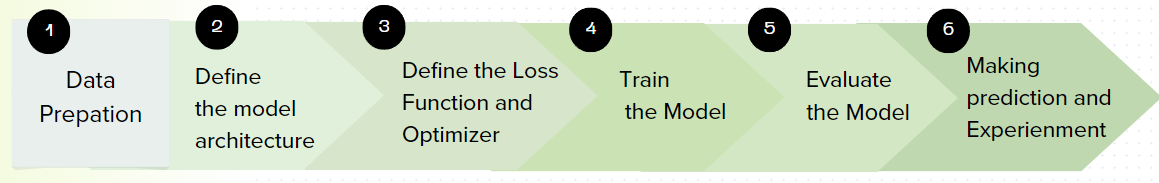



---


# **1. Prepare the Dataset:**

---



## **1.1) Extract images and masks tar.gz files :**




▶ **Extract images and masks tar.gz files**

In [ ]:
with tarfile.open('/content/images.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/images')
with tarfile.open('/content/masks.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/masks')

▶ **Get the list of files in each directory and print their counts**

In [ ]:
images_dir = '/content/images/images'
masks_dir = '/content/masks/masks'

images_list = os.listdir(images_dir)
masks_list = os.listdir(masks_dir)

print(f"Number of images: {len(images_list)}")
print(f"Number of masks: {len(masks_list)}")
print(f".............................")
print(f"Images directories contents: {images_list[:10]}")
print(f"Masks directories contents: {masks_list[:10]}")

Number of images: 590
Number of masks: 590
.............................
Images directories contents: ['ckcudjprd000u3b5y0inb980n.jpg', 'ckcx96ts600103b5y1t1feqnv.jpg', 'ckcx44haz000m3b5ycpibb6ac.jpg', 'ckcudav17000j3b5ynmszygwj.jpg', 'ckd09bezs000c3b5yy33w0pw6.jpg', 'ckcvwgykr00123b5ynu32bppx.jpg', 'ckd4ka6fx000a3b5y5l4rc1b0.jpg', 'ckd01b91d000o3b5yk4p8hydx.jpg', 'ckcuhse7w001o3b5y3cucoi29.jpg', 'ckcua1vxx000s3b5yqqwohpza.jpg']
Masks directories contents: ['ckczzh7yq00063b5ybca6safc.png', 'ckcu9r72l000e3b5yerhwmjut.png', 'ckd49a4rr000e3b5ywtkc4n3s.png', 'ckcvw89rb000p3b5ycvszaz7y.png', 'ckd4jmdk7001e3b5yj8s1c8nb.png', 'ckcuhxfpt001t3b5yco20hyda.png', 'ckcxcvti6000n3b5y52wjx18l.png', 'ckcxcm3p800083b5yio6him4i.png', 'ckd04otrd000d3b5yffhdvb9k.png', 'ckd4goa09000g3b5ym2g6nixv.png']


▶ **Check if image and mask are in the binary range (0,1)**

In [ ]:
images_out_of_range_count = 0
masks_out_of_range_count = 0

# Check if all images are between 0 and 1
for i in images_list:
    image_path = os.path.join(images_dir, i)
    image = np.array(Image.open(image_path).convert("RGB")) / 255.0  # Normalize image to [0,1]

    if not np.all((image >= 0) & (image <= 1)):
        images_out_of_range_count += 1

# Check if all masks are binary (0,1)
for i in masks_list:
    mask_path = os.path.join(masks_dir, i)
    mask = np.array(Image.open(mask_path))

    if not np.all((mask == 0) | (mask == 1)):
        masks_out_of_range_count += 1

# Summary
if images_out_of_range_count == 0:
    print("All training images are within the range [0, 1].")
else:
    print(f"{images_out_of_range_count} training images have values outside the range [0, 1].")

if masks_out_of_range_count == 0:
    print("All training masks are binary (0 or 1).")
else:
    print(f"{masks_out_of_range_count} training masks have values outside the binary range [0, 1].")

All training images are within the range [0, 1].
590 training masks have values outside the binary range [0, 1].


▶ **Plot to see the distribution of both image and mask**

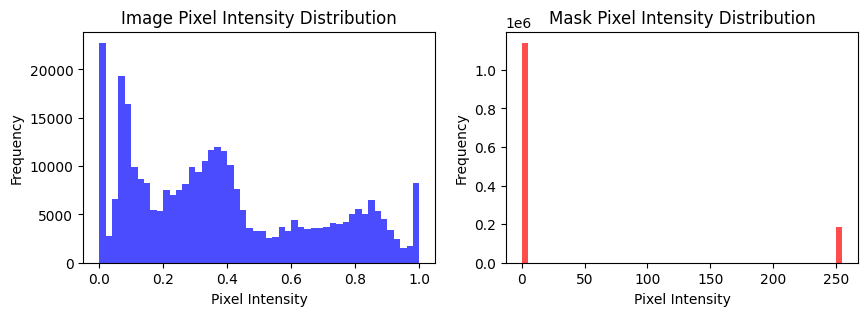

In [ ]:
import matplotlib.pyplot as plt

def plot_histogram(image_name, mask_name):
    image_path = os.path.join(images_dir, image_name)
    mask_path = os.path.join(masks_dir, mask_name)

    # Load image and mask
    image = np.array(Image.open(image_path).convert("L")) / 255.0
    mask = np.array(Image.open(mask_path))
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Image histogram
    axes[0].hist(image.ravel(), bins=50, color='blue', alpha=0.7)
    axes[0].set_title("Image Pixel Intensity Distribution")
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Frequency")

    # Mask histogram
    axes[1].hist(mask.ravel(), bins=50, color='red', alpha=0.7)
    axes[1].set_title("Mask Pixel Intensity Distribution")
    axes[1].set_xlabel("Pixel Intensity")
    axes[1].set_ylabel("Frequency")
    plt.show()

plot_histogram(images_list[0], masks_list[0])


▶ **Find matchine images mask pairs**



In [ ]:
images_dir = '/content/images/images'
masks_dir = '/content/masks/masks'

image_files = {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')}
mask_files = {os.path.splitext(f)[0] for f in os.listdir(masks_dir) if f.endswith('.png')}

# Find common files
common_files = list(image_files.intersection(mask_files))
print(f"Total match images and masks pairs: {len(common_files)}")

Total match images and masks pairs: 590


▶ **List out sample of images and masks**



Loading image: /content/images/images/ckd4iebll00033b5yts7hmhlg.jpg
Loading image: /content/images/images/ckcxcr149000f3b5y6wr9rg7c.jpg
Loading image: /content/images/images/ckd4h7fq300153b5yhdzs5yar.jpg
Loading image: /content/images/images/ckd03cgbx00133b5yaywin2kz.jpg
Loading image: /content/images/images/ckcx9nmko001u3b5yopeccdvo.jpg
Loading mask: /content/masks/masks/ckd4iebll00033b5yts7hmhlg.png
Loading mask: /content/masks/masks/ckcxcr149000f3b5y6wr9rg7c.png
Loading mask: /content/masks/masks/ckd4h7fq300153b5yhdzs5yar.png
Loading mask: /content/masks/masks/ckd03cgbx00133b5yaywin2kz.png
Loading mask: /content/masks/masks/ckcx9nmko001u3b5yopeccdvo.png


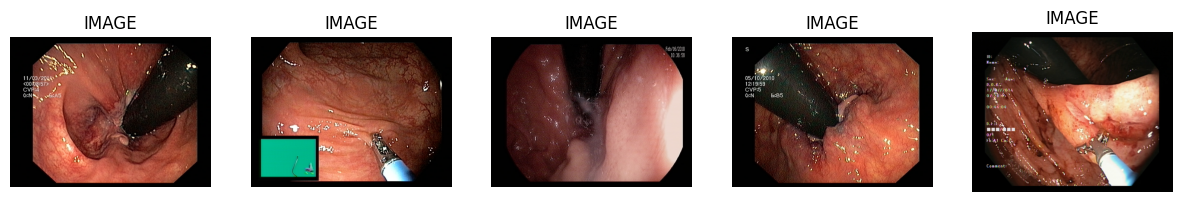

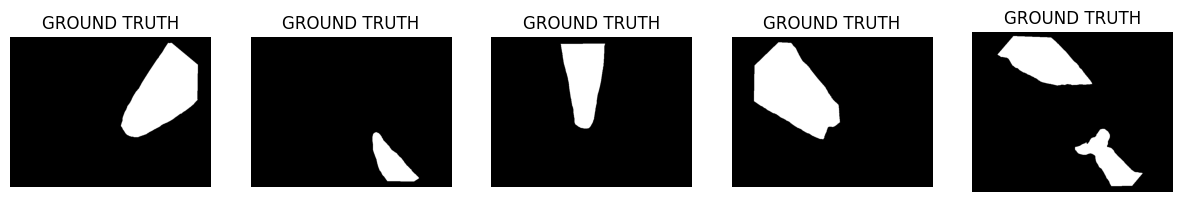

In [ ]:
# Load file names and create a DataFrame with absolute paths
image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir)])
mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir)])
df = pd.DataFrame({'Image File': image_files, 'Mask File': mask_files})
sample = df.sample(n=5, random_state=42)

# Define functions to display images and masks
def generate_sample_images(sample):
    imgs = sample['Image File']

    _, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()

    for i, image_path in enumerate(imgs):
        print(f"Loading image: {image_path}")

        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not load image at path {image_path}")
            ax[i].set_title("IMAGE NOT FOUND")
            ax[i].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
            ax[i].axis('off')
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i].imshow(image)
        ax[i].set_title("IMAGE")
        ax[i].axis('off')

def generate_sample_masks(sample):
    masks = sample['Mask File']

    _, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()

    for i, mask_path in enumerate(masks):
        print(f"Loading mask: {mask_path}")

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Could not load mask at path {mask_path}")
            ax[i].set_title("MASK NOT FOUND")
            ax[i].imshow(np.zeros((64, 64), dtype=np.uint8), cmap='gray')
            ax[i].axis('off')
            continue

        ax[i].imshow(mask, cmap='gray')
        ax[i].set_title("GROUND TRUTH")
        ax[i].axis('off')

# Generate and display sample images and masks
generate_sample_images(sample)
generate_sample_masks(sample)


## **1.2) Load train and test file lists :**

---



In [ ]:
with open('/content/train.txt', 'r') as f:
    train_files = f.read().splitlines()
with open('/content/test.txt', 'r') as f:
    test_files = f.read().splitlines()

print(f"Number of training files: {len(train_files)}")
print(f"Number of testing files: {len(test_files)}")
print(f"...........................................")
print(f"Example of testing files: {train_files[:5]}")
print(f"Example of testing files: {test_files[:5]}")

Number of training files: 472
Number of testing files: 118
...........................................
Example of testing files: ['ckcvw5yhd000m3b5yutirmiad', 'ckcvwpanj001b3b5ysxixpcxy', 'ckcuhbkeo000z3b5yq7v1sm0o', 'ckd0afl7u000a3b5y3crqjxla', 'ckcxb6cne000x3b5ynaznq58f']
Example of testing files: ['ckd4ipizn000d3b5yk2vrbyyz', 'ckcxct8oj000k3b5y9iwia72h', 'ckd4ig3d700043b5y0p70afjj', 'ckd03in4g001d3b5yngyc734r', 'ckcx9nmko001u3b5yopeccdvo']


## **1.3) Define Transformations :**

---



In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),  # Resize to smaller resolution # Use BICUBIC or NEAREST
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Resize to smaller resolution
    transforms.ToTensor() # Converts the masks from [0, 255] to [0, 1] by dividing by 255 and converting to a PyTorch tensor.
])

## **1.4) Custom the dataset :**

---



In [ ]:
class KvasirDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, image_transform=None, mask_transform=None, target_size=(256, 256)):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform  # Use image_transform for images
        self.mask_transform = mask_transform  # Use mask_transform for masks
        self.target_size = target_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        mask_path = os.path.join(self.mask_dir, img_name + '.png')

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Error loading image or mask for {img_name}")


        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)


        # Convert the image from BGR (OpenCV format) to RGB and from NumPy array to PIL Image
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        mask = Image.fromarray(mask)

        # Apply the image transformation
        if self.image_transform:
            image = self.image_transform(image)

        # Apply the mask transformation
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

##  **1.5) Build training and testing datasets - Create DataLoaders for training and testing :**

---



In [ ]:
# Create training and testing datasets
train_dataset = KvasirDataset(train_files, images_dir, masks_dir, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = KvasirDataset(test_files, images_dir, masks_dir, image_transform=image_transform, mask_transform=mask_transform)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, drop_last=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


▶ **Verify by printing a sample bath size**

In [ ]:
# Fetch a random batch from the DataLoader
for images, masks in train_loader:

    # before transformation
    print(f"Resized image size (before transformation): {images.shape}")
    print(f"Resized mask size (before transformation): {masks.shape}")

    # after transformation
    print(f"Image size after transformation: {images.size()}")
    print(f"Mask size after transformation: {masks.size()}")

    break
print('................................................................................')
images, masks = next(iter(train_loader))
print(f"Train batch - Images: {images.shape}, Masks: {masks.shape}")  #  gives the size of each dimension in a tuple form - 8: Batch size (likely 8 images processed at once) - 3: Number of channels (for RGB images - 256x256: Image resolution.
imafes, masks = next(iter(test_loader))
print(f"Train batch = Images: {images.shape}, Masks: {masks.shape}")
print('.................................................................................')
print(f"Image dimension: {np.array(images).ndim}") # the number of dimensions - batch size, channels, height, and widt
print(f"Maak dimension: {np.array(masks).ndim}")

Resized image size (before transformation): torch.Size([8, 3, 256, 256])
Resized mask size (before transformation): torch.Size([8, 1, 256, 256])
Image size after transformation: torch.Size([8, 3, 256, 256])
Mask size after transformation: torch.Size([8, 1, 256, 256])
................................................................................
Train batch - Images: torch.Size([8, 3, 256, 256]), Masks: torch.Size([8, 1, 256, 256])
Train batch = Images: torch.Size([8, 3, 256, 256]), Masks: torch.Size([8, 1, 256, 256])
.................................................................................
Image dimension: 4
Maak dimension: 4


▶ **Print the number of batches in each loader**

In [ ]:
print(f"Number of training batches: {len(train_loader)}") # 472 / 8
print(f"Number of testing batches: {len(test_loader)}") # 118 / 8

Number of training batches: 59
Number of testing batches: 15


▶ **Check if masks in the DataLoader are binary**

In [ ]:
# Check if masks in the DataLoader are binary
for images, masks in train_loader:
    unique_values = torch.unique(masks)
    print("Unique values in a batch of masks:", unique_values)
    if not torch.all((unique_values == 0) | (unique_values == 1)):
        print("Warning: Mask contains values other than 0 and 1.")
    else:
        print("Masks are binary.")
    break  # Check only the first batch


Unique values in a batch of masks: tensor([0., 1.])
Masks are binary.




---


# **2. Define the model architecture**


---



In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder part (contracting path)
        self.enc1 = self.conv_block(3, 64, p=0.3)  # Adding dropout in each block
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self.conv_block(64, 128, p=0.3)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self.conv_block(128, 256, p=0.3)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = self.conv_block(256, 512, p=0.3)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck (bottom of the U)
        self.bottleneck = self.conv_block(512, 1024, p=0.3)

        # Decoder part (expanding path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512, p=0.3)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256, p=0.3)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128, p=0.3)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64, p=0.3)

        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels, p=0.3):
        """Convolutional block with dropout."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p),  # Dropout added here with probability p
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p)  # Dropout added after the second convolution
        )

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        p2 = self.pool2(x2)

        x3 = self.enc3(p2)
        p3 = self.pool3(x3)

        x4 = self.enc4(p3)
        p4 = self.pool4(x4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with skip connections
        u4 = self.upconv4(b)
        d4 = torch.cat([u4, x4], dim=1)  # Skip connection
        d4 = self.dec4(d4)

        u3 = self.upconv3(d4)
        d3 = torch.cat([u3, x3], dim=1)  # Skip connection
        d3 = self.dec3(d3)

        u2 = self.upconv2(d3)
        d2 = torch.cat([u2, x2], dim=1)  # Skip connection
        d2 = self.dec2(d2)

        u1 = self.upconv1(d2)
        d1 = torch.cat([u1, x1], dim=1)  # Skip connection
        d1 = self.dec1(d1)

        # Final output layer
        out = self.final(d1)
        return torch.sigmoid(out)  # Sigmoid for binary segmentation must remains the same




---


# **3. Train the model**

---






#### ▶ **Calculating the metrics**

In [ ]:
def calculate_metrics_function(true_mask, predicted_masks, smooth=1e-6):
    true_mask = true_mask.to(predicted_masks.device)
    true_masks_flat = true_mask.view(-1).cpu().numpy()
    predicted_masks_flat = predicted_masks.view(-1).cpu().numpy()

    # True Positives, False Positives, False Negatives
    TruePositive = np.sum((true_masks_flat == 1) & (predicted_masks_flat == 1))
    FalsePositive = np.sum((true_masks_flat == 0) & (predicted_masks_flat == 1))
    FalseNegative = np.sum((true_masks_flat == 1) & (predicted_masks_flat == 0))

    # Accuracy
    total_pixels = true_masks_flat.size
    accuracy = (TruePositive + (total_pixels - TruePositive - FalsePositive - FalseNegative)) / total_pixels

    # Precision, Recall, F1-score, DSC
    precision_score = TruePositive / (TruePositive + FalsePositive) if (TruePositive + FalsePositive) > 0 else 0
    recall_score = TruePositive / (TruePositive + FalseNegative) if (TruePositive + FalseNegative) > 0 else 0
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score) if (precision_score + recall_score) > 0 else 0
    dcs_score = (2 * TruePositive + smooth) / (2 * TruePositive + FalsePositive + FalseNegative + smooth)

    # IoU (Intersection over Union)
    union = TruePositive + FalsePositive + FalseNegative
    iou = (TruePositive + smooth) / (union + smooth)

    return accuracy * 100, precision_score, recall_score, f1_score, dcs_score, iou



#### ▶ **Train function**

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
  model.train()
  train_loss = 0.0
  correct_pixels = 0
  total_pixels = 0
  total_dsc = 0
  total_iou = 0

  for images, masks in train_loader:
      images, masks = images.to(device), masks.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, masks)
      train_loss += loss.item()

      predicted_masks = (torch.sigmoid(outputs) > 0.5).float()


      # calculate training accuracy
      predicted_masks = (outputs > 0.5).float()
      correct_pixels += (predicted_masks == masks).float().sum().item()
      total_pixels += masks.numel()

      # Calculate Dice Coe
      _,_,_,_,dsc, iou = calculate_metrics_function(masks, predicted_masks)
      total_dsc += dsc
      total_iou += iou

      loss.backward()
      optimizer.step()

  avg_train_loss = train_loss / len(train_loader)
  train_accuracy = 100 * correct_pixels / total_pixels
  avg_dsc = total_dsc / len(train_loader)
  avg_iou = total_iou / len(train_loader)

  return avg_train_loss, train_accuracy, avg_dsc, avg_iou



---


# **4. Test the model**

---






In [ ]:
def test_model(model, test_loader, criterion, device):
  model.eval()
  test_loss = 0
  all_true_masks = []
  all_predicted_masks = []

  with torch.no_grad():
    for images, masks in test_loader:

      images, masks = images.to(device), masks.to(device)

      # Forward pass function
      outputs = model(images)
      loss = criterion(outputs, masks)
      test_loss += loss.item()

      # Save true and predicted masks
      all_true_masks.append(masks)
      all_predicted_masks.append((outputs > 0.5).float())

  # Conclude all the results across batches
  all_true_masks = torch.cat(all_true_masks)
  all_predicted_masks = torch.cat(all_predicted_masks)

  # Calculate metrics
  accuracy, precision_score, recall_score, f1_score, dcs_score, iou = calculate_metrics_function(all_true_masks, all_predicted_masks)
  avg_test_loss = test_loss / len(test_loader)

  return avg_test_loss, accuracy, precision_score, recall_score, f1_score, dcs_score, iou



---




#  **5. Optimizer Experiment - Overview**

---





---


## 🌱 **Optimizer 1: Adam (Adaptive Moment Estimation)**

---



In [ ]:
import wandb

# Initialize WandB
# Initialize WandB
wandb.init(project="Optimizer_experiment", entity="kandidat18-kristiania-university-college", config={
    "optimizer": "SGD",
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR",
    "epochs": 30
})

# Reinitialize the model and optimizer
model = UNet()
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Early stopping parameters
patience = 5
best_test_dsc = 0
epochs_no_improve = 0

# Lists to store metrics' results
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_dsc_values = []
test_dsc_values = []
train_iou_values = []
test_iou_values = []

epochs_number = 30

# Training loop
for epoch in range(epochs_number):
    print(f"Epoch [{epoch + 1}/{epochs_number}]")

    # Training step
    train_loss, train_accuracy, train_dsc, train_iou = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_dsc_values.append(train_dsc)
    train_iou_values.append(train_iou)

    # Testing step
    test_loss, test_accuracy, precision_score, recall_score, f1_score, test_dsc, test_iou = test_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_dsc_values.append(test_dsc)
    test_iou_values.append(test_iou)

    # Log both training and testing metrics to WandB
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Train DSC": train_dsc,
        "Train IoU": train_iou,
        "Test Loss": test_loss,
        "Test Accuracy": test_accuracy,
        "Test Precision": precision_score,
        "Test Recall": recall_score,
        "Test F1-Score": f1_score,
        "Test DSC": test_dsc,
        "Test IoU": test_iou
    })

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train DSC: {train_dsc:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
          f"Test Precision: {precision_score:.4f}, Test Recall: {recall_score:.4f}, "
          f"Test F1-Score: {f1_score:.4f}, Test DSC: {test_dsc:.4f}, Test IoU: {test_iou:.4f}\n")

    # Step the scheduler based on test loss
    scheduler.step(test_loss)

    # Early stopping check on Test DSC
    if test_dsc > best_test_dsc:
        best_test_dsc = test_dsc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check if early stopping condition is met
    if epochs_no_improve >= patience:
        print("Early stopping break!")
        break

# Finish the WandB run
wandb.finish()


Epoch [1/30]
Train Loss: 0.3176, Train Accuracy: 89.95%, Train DSC: 0.0000, Train IoU: 0.0000
Test Loss: 0.2149, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [2/30]
Train Loss: 0.2156, Train Accuracy: 90.17%, Train DSC: 0.0553, Train IoU: 0.0336
Test Loss: 0.1740, Test Accuracy: 93.16%, Test Precision: 0.6549, Test Recall: 0.5630, Test F1-Score: 0.6055, Test DSC: 0.6055, Test IoU: 0.4342

Epoch [3/30]
Train Loss: 0.1788, Train Accuracy: 93.10%, Train DSC: 0.5712, Train IoU: 0.4139
Test Loss: 0.1303, Test Accuracy: 94.67%, Test Precision: 0.9090, Test Recall: 0.4759, Test F1-Score: 0.6247, Test DSC: 0.6247, Test IoU: 0.4542

Epoch [4/30]
Train Loss: 0.1655, Train Accuracy: 93.43%, Train DSC: 0.6029, Train IoU: 0.4430
Test Loss: 0.2040, Test Accuracy: 92.81%, Test Precision: 0.5798, Test Recall: 0.8300, Test F1-Score: 0.6827, Test DSC: 0.6827, Test IoU: 0.5182

Epoch [5/30]
Train Loss: 0.1675, Train A



---


##  ▶ **Compare Original Image and Ground Truth Mask with Predicted Mask**

---



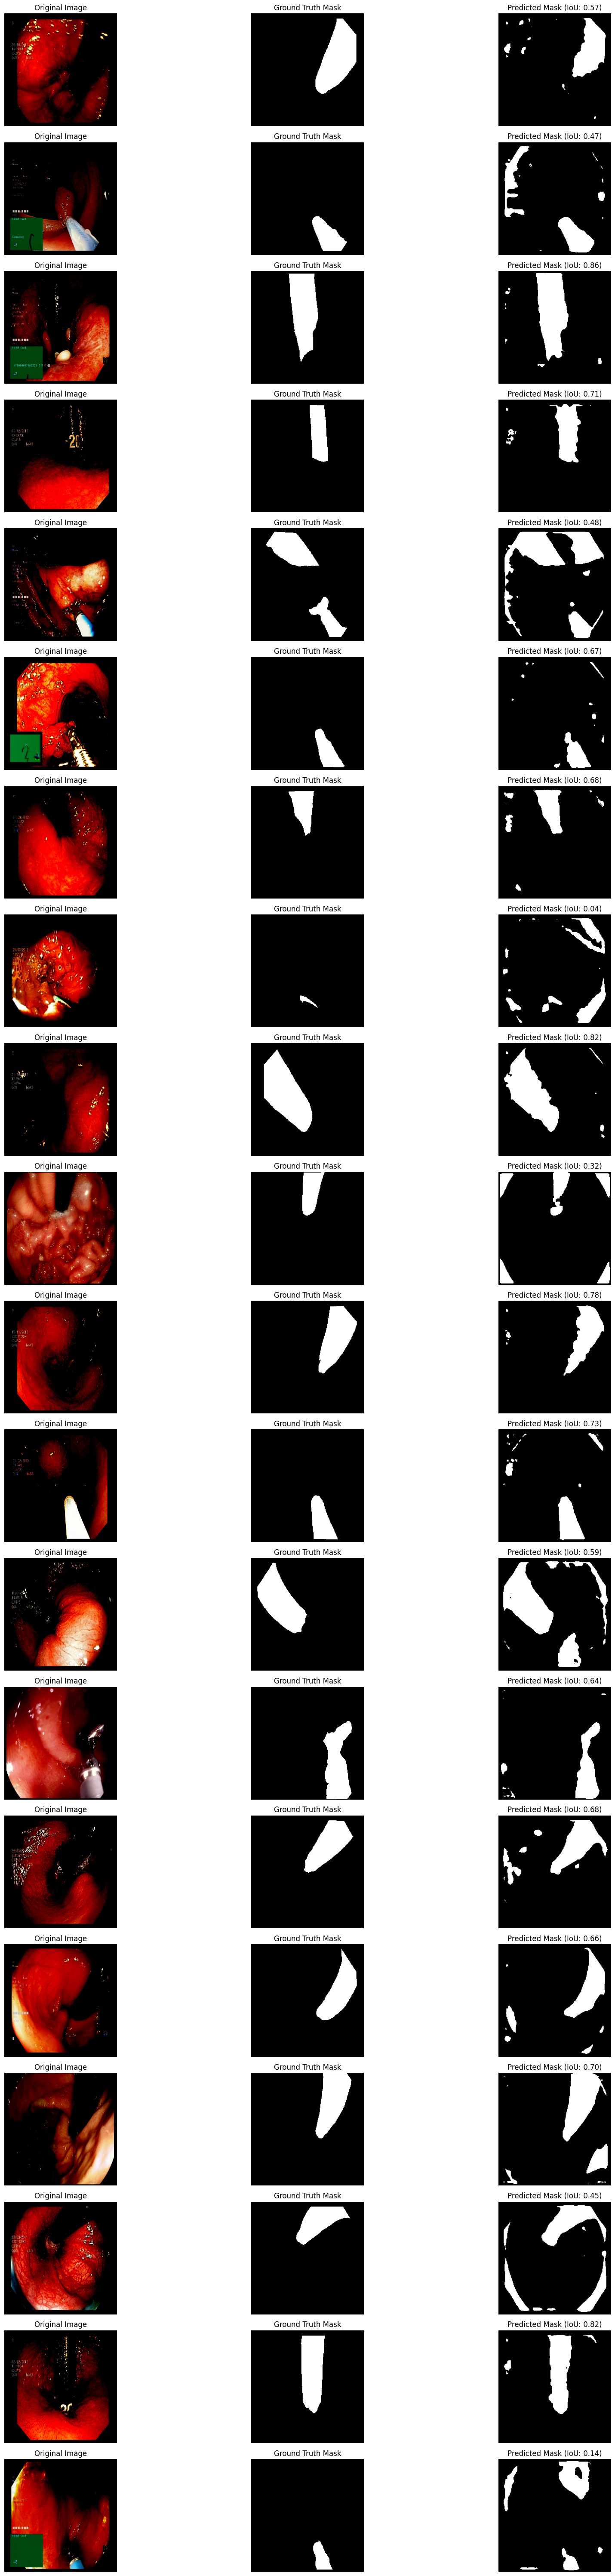

Image 1 IoU: 0.57
Image 2 IoU: 0.47
Image 3 IoU: 0.86
Image 4 IoU: 0.71
Image 5 IoU: 0.48
Image 6 IoU: 0.67
Image 7 IoU: 0.68
Image 8 IoU: 0.04
Image 9 IoU: 0.82
Image 10 IoU: 0.32
Image 11 IoU: 0.78
Image 12 IoU: 0.73
Image 13 IoU: 0.59
Image 14 IoU: 0.64
Image 15 IoU: 0.68
Image 16 IoU: 0.66
Image 17 IoU: 0.70
Image 18 IoU: 0.45
Image 19 IoU: 0.82
Image 20 IoU: 0.14


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def display_predictions(images, true_masks, predicted_masks, ious, num_images=20):
    plt.figure(figsize=(20, num_images * 3))
    for i in range(num_images):
        for j, (img, title) in enumerate(zip(
            [images[i].cpu().numpy().transpose(1, 2, 0), true_masks[i].cpu().numpy().squeeze(), predicted_masks[i].cpu().numpy().squeeze()],
            ["Original Image", "Ground Truth Mask", f"Predicted Mask (IoU: {ious[i]:.2f})"]
        )):
            plt.subplot(num_images, 3, i * 3 + j + 1)
            plt.imshow(img, cmap='gray' if j else None)
            plt.title(title)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

def calculate_iou_per_image(true_masks, predicted_masks, threshold=0.5):
    return [(pred_mask := (predicted_masks[i] > threshold).float(), true_mask := true_masks[i].float(),
             (intersection := (pred_mask * true_mask).sum()),
             union := pred_mask.sum() + true_mask.sum() - intersection,
             0 if union == 0 else intersection / union)[-1].item()
            for i in range(true_masks.size(0))]

# Collect images from multiple batches
collected_images, collected_masks, collected_pred_masks, collected_ious = [], [], [], []
for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        predicted_masks = (model(images) > 0.49).float()
    collected_images.extend(images.cpu())
    collected_masks.extend(masks.cpu())
    collected_pred_masks.extend(predicted_masks.cpu())
    collected_ious.extend(calculate_iou_per_image(masks, predicted_masks))
    if len(collected_images) >= 20:
        break

# Trim and convert collected data to tensors
collected_images, collected_masks, collected_pred_masks = map(lambda x: torch.stack(x)[:20], [collected_images, collected_masks, collected_pred_masks])
collected_ious = collected_ious[:20]

# Show predictions and IoUs
display_predictions(collected_images, collected_masks, collected_pred_masks, collected_ious)
for idx, iou in enumerate(collected_ious):
    print(f"Image {idx + 1} IoU: {iou:.2f}")




---


## 🌱 **Optimizer 2: SGD (Stochastic Gradient Descent)**

---



In [ ]:
import wandb

# Reinitialize the model and optimizer
model = UNet()
criterion = nn.BCELoss()

# Change optimizer to SGD
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Initialize WandB
wandb.init(project="Optimizer_experiment", entity="kandidat18-kristiania-university-college", config={
    "optimizer": "SGD",
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR",
    "epochs": 30
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
patience = 5
best_test_dsc = 0
epochs_no_improve = 0


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_dsc_values = []
test_dsc_values = []
train_iou_values = []
test_iou_values = []

epochs_number = 30

# Training loop
for epoch in range(epochs_number):
    print(f"Epoch [{epoch + 1}/{epochs_number}]")

    # Training step
    train_loss, train_accuracy, train_dsc, train_iou = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_dsc_values.append(train_dsc)
    train_iou_values.append(train_iou)

    # Testing step
    test_loss, test_accuracy, precision_score, recall_score, f1_score, test_dsc, test_iou = test_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_dsc_values.append(test_dsc)
    test_iou_values.append(test_iou)

    # Log both training and testing metrics to WandB
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Train DSC": train_dsc,
        "Train IoU": train_iou,
        "Test Loss": test_loss,
        "Test Accuracy": test_accuracy,
        "Test Precision": precision_score,
        "Test Recall": recall_score,
        "Test F1-Score": f1_score,
        "Test DSC": test_dsc,
        "Test IoU": test_iou
    })

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train DSC: {train_dsc:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
          f"Test Precision: {precision_score:.4f}, Test Recall: {recall_score:.4f}, "
          f"Test F1-Score: {f1_score:.4f}, Test DSC: {test_dsc:.4f}, Test IoU: {test_iou:.4f}\n")

    # Step the scheduler
    scheduler.step()

    # Early stopping check on Test DSC
    if test_dsc > best_test_dsc:
        best_test_dsc = test_dsc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check if early stopping condition is met
    if epochs_no_improve >= patience:
        print("Early stopping break!")
        break

# Finish the WandB run
wandb.finish()


Epoch [1/30]
Train Loss: 0.6575, Train Accuracy: 76.01%, Train DSC: 0.0465, Train IoU: 0.0252
Test Loss: 0.6000, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [2/30]
Train Loss: 0.5506, Train Accuracy: 89.95%, Train DSC: 0.0000, Train IoU: 0.0000
Test Loss: 0.4865, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [3/30]
Train Loss: 0.4220, Train Accuracy: 89.95%, Train DSC: 0.0000, Train IoU: 0.0000
Test Loss: 0.3425, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [4/30]
Train Loss: 0.3386, Train Accuracy: 89.95%, Train DSC: 0.0000, Train IoU: 0.0000
Test Loss: 0.3086, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [5/30]
Train Loss: 0.3232, Train A



---


##  ▶ **Compare Original Image and Ground Truth Mask with Predicted Mask**

---



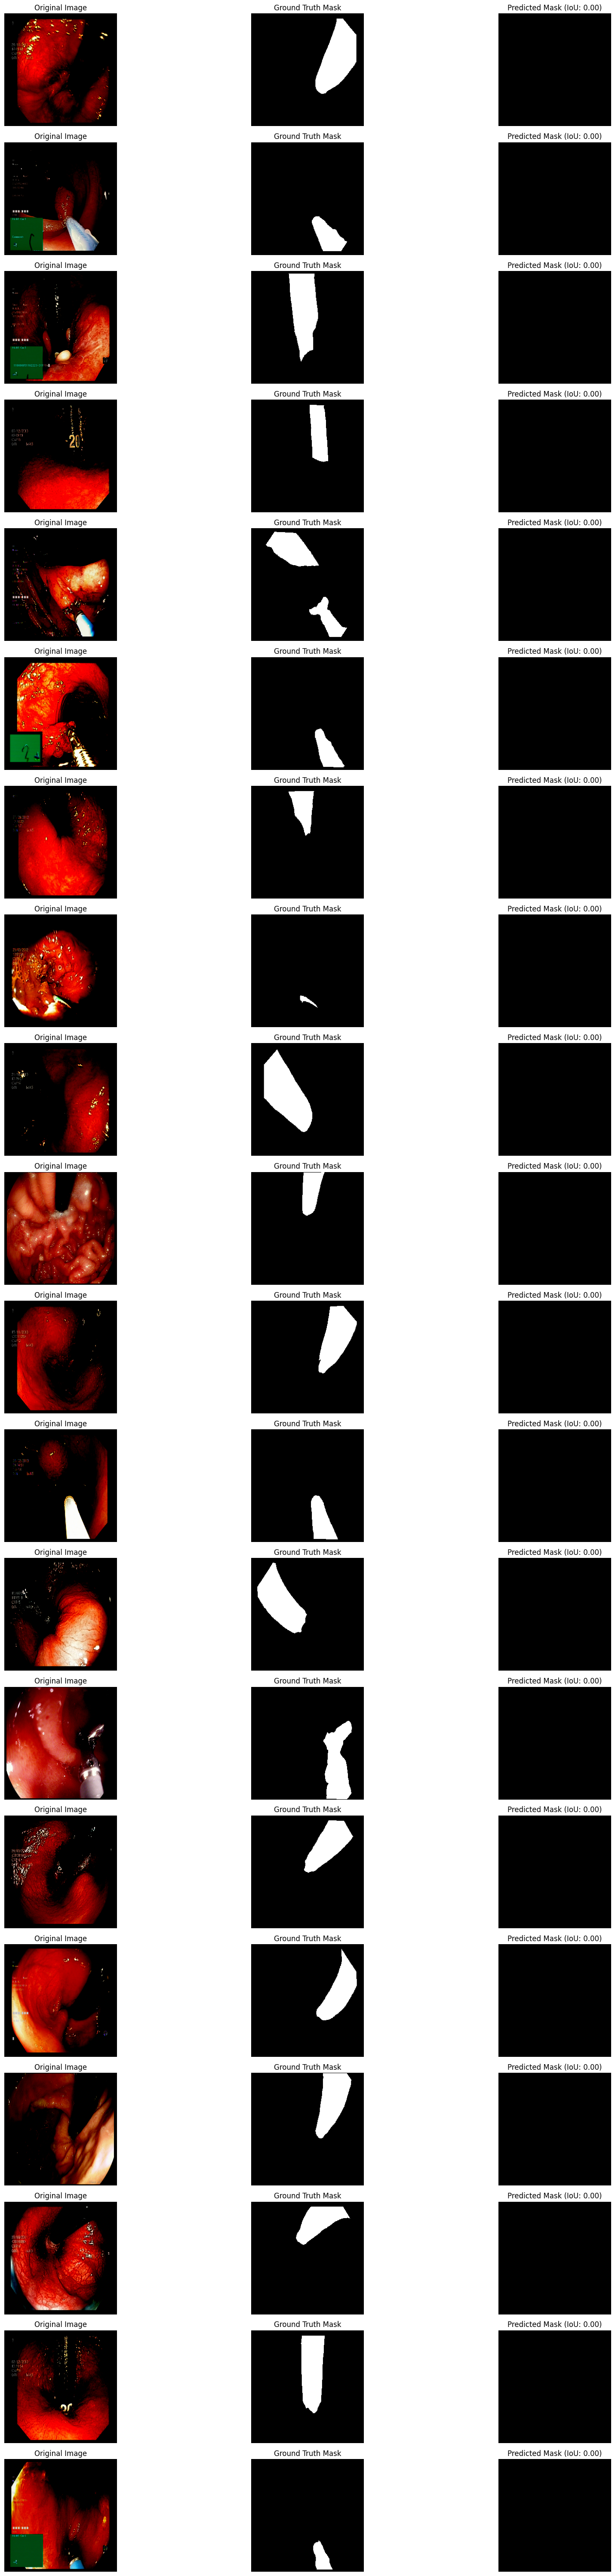

Image 1 IoU: 0.00
Image 2 IoU: 0.00
Image 3 IoU: 0.00
Image 4 IoU: 0.00
Image 5 IoU: 0.00
Image 6 IoU: 0.00
Image 7 IoU: 0.00
Image 8 IoU: 0.00
Image 9 IoU: 0.00
Image 10 IoU: 0.00
Image 11 IoU: 0.00
Image 12 IoU: 0.00
Image 13 IoU: 0.00
Image 14 IoU: 0.00
Image 15 IoU: 0.00
Image 16 IoU: 0.00
Image 17 IoU: 0.00
Image 18 IoU: 0.00
Image 19 IoU: 0.00
Image 20 IoU: 0.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def display_predictions(images, true_masks, predicted_masks, ious, num_images=20):
    plt.figure(figsize=(20, num_images * 3))
    for i in range(num_images):
        for j, (img, title) in enumerate(zip(
            [images[i].cpu().numpy().transpose(1, 2, 0), true_masks[i].cpu().numpy().squeeze(), predicted_masks[i].cpu().numpy().squeeze()],
            ["Original Image", "Ground Truth Mask", f"Predicted Mask (IoU: {ious[i]:.2f})"]
        )):
            plt.subplot(num_images, 3, i * 3 + j + 1)
            plt.imshow(img, cmap='gray' if j else None)
            plt.title(title)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

def calculate_iou_per_image(true_masks, predicted_masks, threshold=0.5):
    return [(pred_mask := (predicted_masks[i] > threshold).float(), true_mask := true_masks[i].float(),
             (intersection := (pred_mask * true_mask).sum()),
             union := pred_mask.sum() + true_mask.sum() - intersection,
             0 if union == 0 else intersection / union)[-1].item()
            for i in range(true_masks.size(0))]

# Collect images from multiple batches
collected_images, collected_masks, collected_pred_masks, collected_ious = [], [], [], []
for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        predicted_masks = (model(images) > 0.49).float()
    collected_images.extend(images.cpu())
    collected_masks.extend(masks.cpu())
    collected_pred_masks.extend(predicted_masks.cpu())
    collected_ious.extend(calculate_iou_per_image(masks, predicted_masks))
    if len(collected_images) >= 20:
        break

# Trim and convert collected data to tensors
collected_images, collected_masks, collected_pred_masks = map(lambda x: torch.stack(x)[:20], [collected_images, collected_masks, collected_pred_masks])
collected_ious = collected_ious[:20]

# Show predictions and IoUs
display_predictions(collected_images, collected_masks, collected_pred_masks, collected_ious)
for idx, iou in enumerate(collected_ious):
    print(f"Image {idx + 1} IoU: {iou:.2f}")




---


## 🌱 **Optimizer 3: RMSprop (Root Mean Square Propagation)**

---



In [ ]:
# Reinitialize the model and optimizer
model = UNet()
criterion = nn.BCELoss()

# Change optimizer to RMSprop
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Initialize WandB
wandb.init(project="Optimizer_experiment", entity="kandidat18-kristiania-university-college", config={
    "optimizer": "SGD",
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR",
    "epochs": 30
})

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
images, masks = images.to(device), masks.to(device)

# Early stopping parameters
patience = 5
best_test_dsc = 0
epochs_no_improve = 0

# Lists to store metrics' results
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_dsc_values = []
test_dsc_values = []
train_iou_values = []
test_iou_values = []

epochs_number = 30

# Training loop
for epoch in range(epochs_number):
    print(f"Epoch [{epoch + 1}/{epochs_number}]")

    # Training step
    train_loss, train_accuracy, train_dsc, train_iou = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_dsc_values.append(train_dsc)
    train_iou_values.append(train_iou)

    # Testing step
    test_loss, test_accuracy, precision_score, recall_score, f1_score, test_dsc, test_iou = test_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_dsc_values.append(test_dsc)
    test_iou_values.append(test_iou)

    # Log both training and testing metrics to WandB
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Train DSC": train_dsc,
        "Train IoU": train_iou,
        "Test Loss": test_loss,
        "Test Accuracy": test_accuracy,
        "Test Precision": precision_score,
        "Test Recall": recall_score,
        "Test F1-Score": f1_score,
        "Test DSC": test_dsc,
        "Test IoU": test_iou
    })

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train DSC: {train_dsc:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
          f"Test Precision: {precision_score:.4f}, Test Recall: {recall_score:.4f}, "
          f"Test F1-Score: {f1_score:.4f}, Test DSC: {test_dsc:.4f}, Test IoU: {test_iou:.4f}\n")

    # Step the scheduler based on test loss
    scheduler.step(test_loss)

    # Early stopping check on Test DSC
    if test_dsc > best_test_dsc:
        best_test_dsc = test_dsc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check if early stopping condition is met
    if epochs_no_improve >= patience:
        print("Early stopping break!")
        break

# Finish the WandB run
wandb.finish()


Epoch [1/30]
Train Loss: 9.6135, Train Accuracy: 89.94%, Train DSC: 0.0001, Train IoU: 0.0001
Test Loss: 9.3111, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [2/30]
Train Loss: 10.0518, Train Accuracy: 89.94%, Train DSC: 0.0000, Train IoU: 0.0000
Test Loss: 9.3111, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [3/30]
Train Loss: 10.0518, Train Accuracy: 89.94%, Train DSC: 0.0001, Train IoU: 0.0000
Test Loss: 9.3111, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [4/30]
Train Loss: 10.0528, Train Accuracy: 89.94%, Train DSC: 0.0001, Train IoU: 0.0000
Test Loss: 9.3111, Test Accuracy: 90.68%, Test Precision: 0.0000, Test Recall: 0.0000, Test F1-Score: 0.0000, Test DSC: 0.0000, Test IoU: 0.0000

Epoch [5/30]
Train Loss: 10.0545, Tra



---


##  ▶ **Compare Original Image and Ground Truth Mask with Predicted Mask**

---



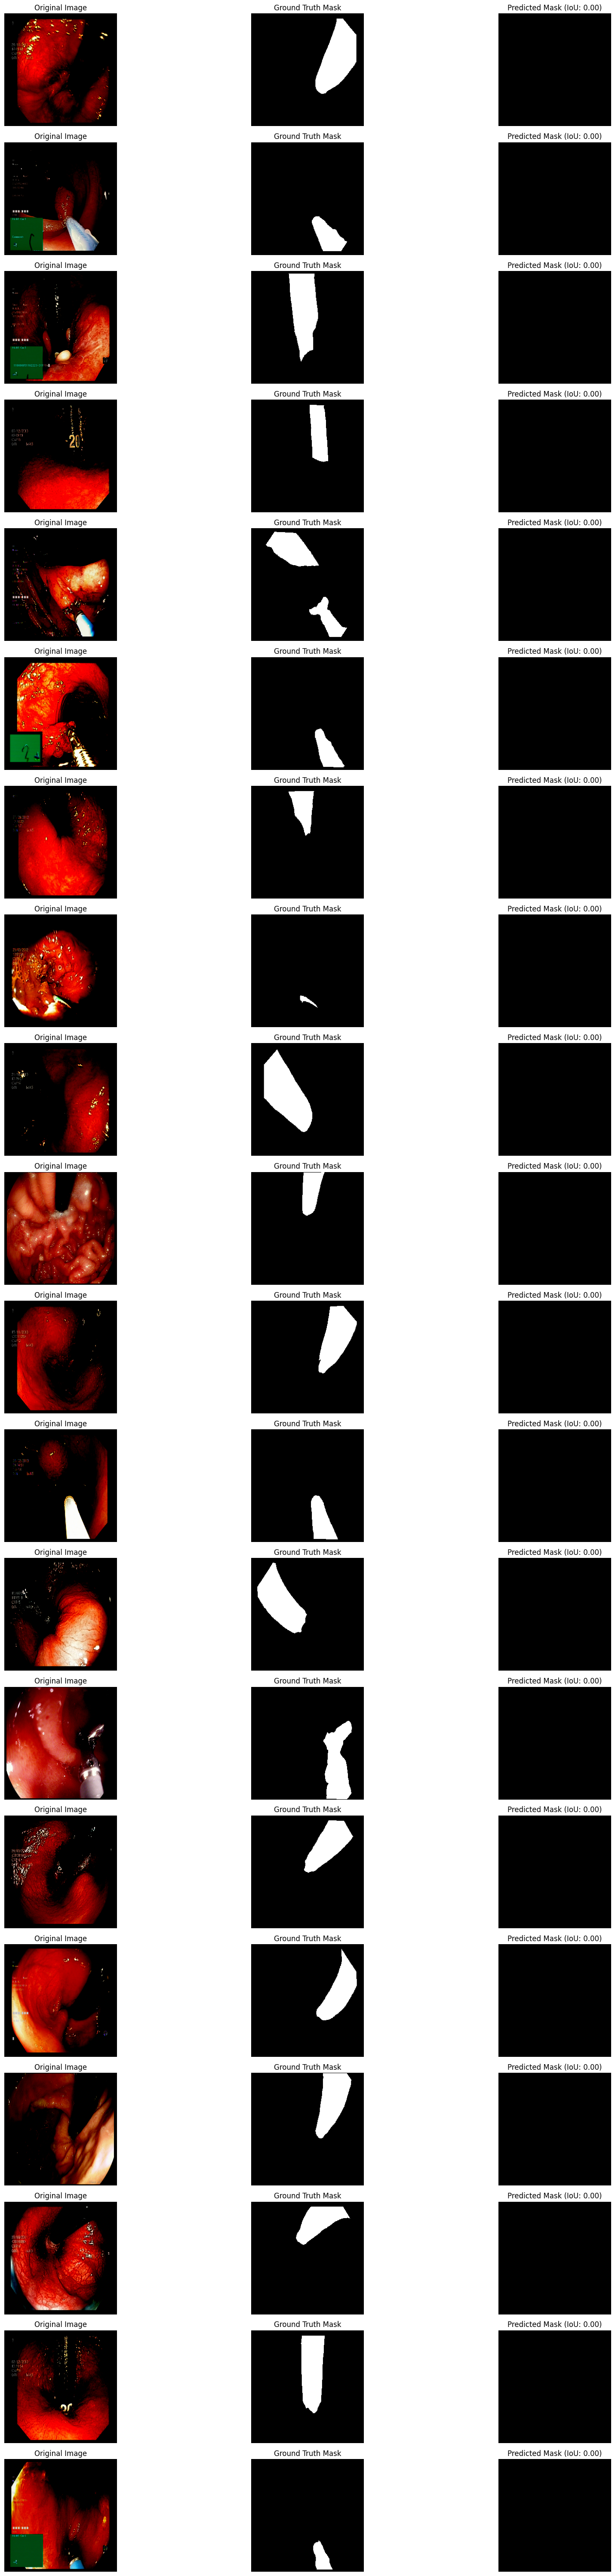

Image 1 IoU: 0.00
Image 2 IoU: 0.00
Image 3 IoU: 0.00
Image 4 IoU: 0.00
Image 5 IoU: 0.00
Image 6 IoU: 0.00
Image 7 IoU: 0.00
Image 8 IoU: 0.00
Image 9 IoU: 0.00
Image 10 IoU: 0.00
Image 11 IoU: 0.00
Image 12 IoU: 0.00
Image 13 IoU: 0.00
Image 14 IoU: 0.00
Image 15 IoU: 0.00
Image 16 IoU: 0.00
Image 17 IoU: 0.00
Image 18 IoU: 0.00
Image 19 IoU: 0.00
Image 20 IoU: 0.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def display_predictions(images, true_masks, predicted_masks, ious, num_images=20):
    plt.figure(figsize=(20, num_images * 3))
    for i in range(num_images):
        for j, (img, title) in enumerate(zip(
            [images[i].cpu().numpy().transpose(1, 2, 0), true_masks[i].cpu().numpy().squeeze(), predicted_masks[i].cpu().numpy().squeeze()],
            ["Original Image", "Ground Truth Mask", f"Predicted Mask (IoU: {ious[i]:.2f})"]
        )):
            plt.subplot(num_images, 3, i * 3 + j + 1)
            plt.imshow(img, cmap='gray' if j else None)
            plt.title(title)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

def calculate_iou_per_image(true_masks, predicted_masks, threshold=0.5):
    return [(pred_mask := (predicted_masks[i] > threshold).float(), true_mask := true_masks[i].float(),
             (intersection := (pred_mask * true_mask).sum()),
             union := pred_mask.sum() + true_mask.sum() - intersection,
             0 if union == 0 else intersection / union)[-1].item()
            for i in range(true_masks.size(0))]

# Collect images from multiple batches
collected_images, collected_masks, collected_pred_masks, collected_ious = [], [], [], []
for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        predicted_masks = (model(images) > 0.49).float()
    collected_images.extend(images.cpu())
    collected_masks.extend(masks.cpu())
    collected_pred_masks.extend(predicted_masks.cpu())
    collected_ious.extend(calculate_iou_per_image(masks, predicted_masks))
    if len(collected_images) >= 20:
        break

# Trim and convert collected data to tensors
collected_images, collected_masks, collected_pred_masks = map(lambda x: torch.stack(x)[:20], [collected_images, collected_masks, collected_pred_masks])
collected_ious = collected_ious[:20]

# Show predictions and IoUs
display_predictions(collected_images, collected_masks, collected_pred_masks, collected_ious)
for idx, iou in enumerate(collected_ious):
    print(f"Image {idx + 1} IoU: {iou:.2f}")


## 🌟 **A comparison based on three optimizer (Adam, SGD and RMSprop)**


---


| **Metric**           | **Adam (Green)**          | **SGD (Blue)**            | **RMSprop (Red)**         |
|-----------------------|-------------------|--------------------|---------------------|
| **Epoch**            | 15               | 6                  | 6                   |
| **Test Accuracy**    | 95.56749         | 90.67824          | 90.67824           |
| **Test DSC**         | 0.74986          | 0.0               | 0.0                |
| **Test F1-Score**    | 0.74986          | 0.0               | 0.0                |
| **Test IoU**         | 0.59982          | 0.0               | 0.0                |
| **Test Loss**        | 0.10917          | 0.29081           | 9.31106            |
| **Test Precision**   | 0.79108          | 0.0               | 0.0                |
| **Test Recall**      | 0.71273          | 0.0               | 0.0                |
| **Train Accuracy**   | 92.84353         | 89.94629          | 89.94032           |
| **Train DSC**        | 0.52079          | 0.0               | 0.00015            |
| **Train IoU**        | 0.38155          | 0.0               | 8e-05              |
| **Train Loss**       | 0.16619          | 0.31453           | 10.05688           |


## ▶ **Plot the result into Wandb Report**


---

To keep the code more intuitive and easier to follow, we integrated the results with the W&B (Weights & Biases) library, which automatically generates interactive metric plots. You can view the interactive plots by following this link:
[Click to view an interactive visualization](https://api.wandb.ai/links/kandidat18-kristiania-university-college/bbsgeqeh)



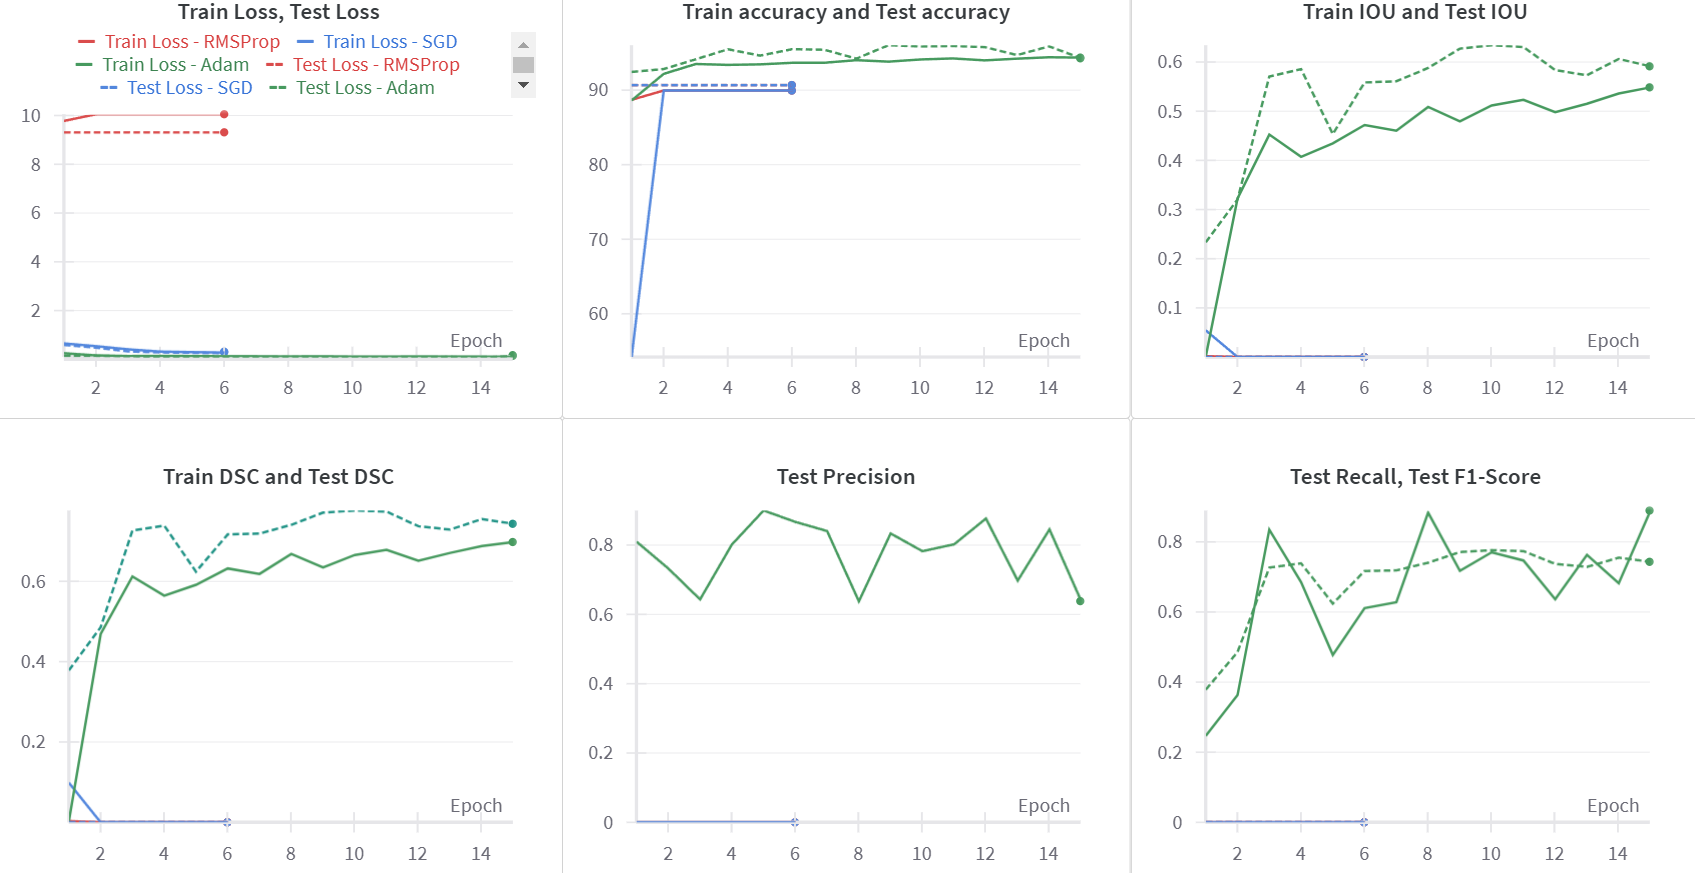

In [ ]:
torch.save(model.state_dict(), 'unet_model.pth')